# **Classical Approach - Monte Carlo Simulations**

In this approach, we try to find the price of an option by simulating how the stock price might move in the future. We generate many random possible paths for the stock price till the expiry date and then calculate how much profit the option would give in each case. After that, we take the average of all those payoffs and bring it back to the present value using the risk-free interest rate.
So instead of solving complex formulas, we let the computer imagine thousands of future scenarios and use their average result to estimate what the option should be worth today.

**Importing Important Libraries**

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

I simulated 5,000 possible stock price paths using **Geometric Brownian Motion**. Then I calculated the average discounted payoff of a European call option to estimate its fair price.I have also included a confidence interval to show the statistical reliability of the result.

In [ ]:
# Simulating European Call Option using random price paths


# Reproducibility
np.random.seed(42)

# parameters

initial_price = 50         # starting stock price (S0)
strike_price = 55           # strike price (K)
risk_free_rate = 0.05       # annual risk-free interest rate (r)
volatility = 0.4             # volatility of the stock (sigma)
time_to_maturity = 1       # time to expiry in years
steps = 100                 # number of time intervals
dt = time_to_maturity / steps
num_paths = 5000          # number of simulated paths



Z = np.random.randn(steps, num_paths)               # Generating random normal variables

#Geometric Brownian motion paths
price_paths = np.zeros((steps + 1, num_paths))
price_paths[0] = initial_price

for t in range(1, steps + 1):
    price_paths[t] = price_paths[t-1] * np.exp(
        (risk_free_rate - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * Z[t-1]
    )

# Computing payoffs for European Call Option at maturity
payoffs = np.maximum(price_paths[-1] - strike_price, 0)

# Estimating option price
option_price = np.exp(-risk_free_rate * time_to_maturity) * np.mean(payoffs)



#standard error for confidence interval
std_error = np.std(payoffs) / np.sqrt(num_paths)

print(f"Estimated European Call Option Price: ${option_price:.4f}")
print(f"95% Confidence Interval: ±{1.96 * std_error:.4f}")

Estimated European Call Option Price: $6.7909
95% Confidence Interval: ±0.4016


**Sample paths (100 possible paths our stock is taking)**

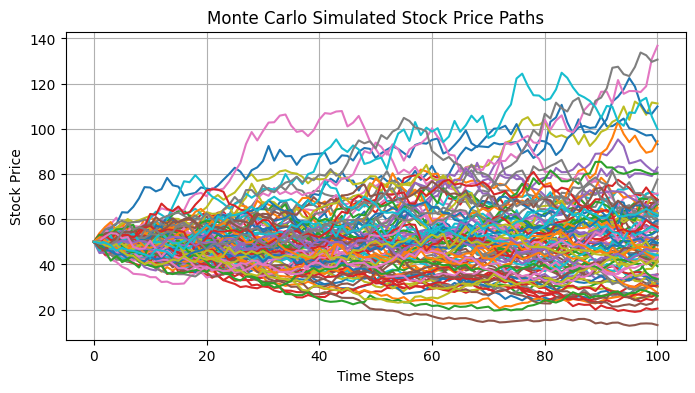

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(price_paths[:, :100])
plt.title("Monte Carlo Simulated Stock Price Paths")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()


**Visualizing distribution of simulated final stock prices**

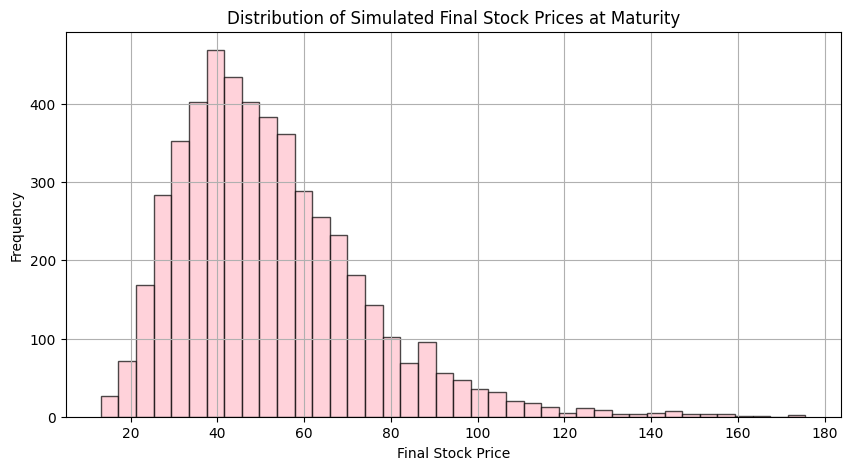

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(price_paths[-1], bins=40, color='pink', edgecolor='black', alpha=0.7)
plt.title("Distribution of Simulated Final Stock Prices at Maturity")
plt.xlabel("Final Stock Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**Distribution of payoffs**

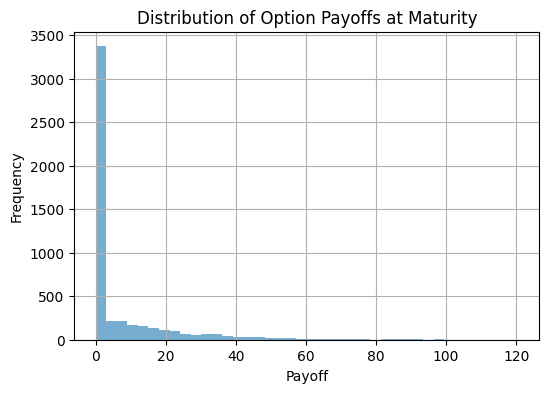

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(payoffs, bins=40, alpha=0.6)
plt.title("Distribution of Option Payoffs at Maturity")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# **Quantum Approach - Using Quantum Amplitude Estimation**

In [ ]:
!pip install qiskit qiskit-finance qiskit-aer qiskit_ibm_runtime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-algorithms

**Importing Qiskit Packages**

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

In [ ]:
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.primitives import StatevectorSampler


In [ ]:
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_algorithms.state_fidelities import ComputeUncompute


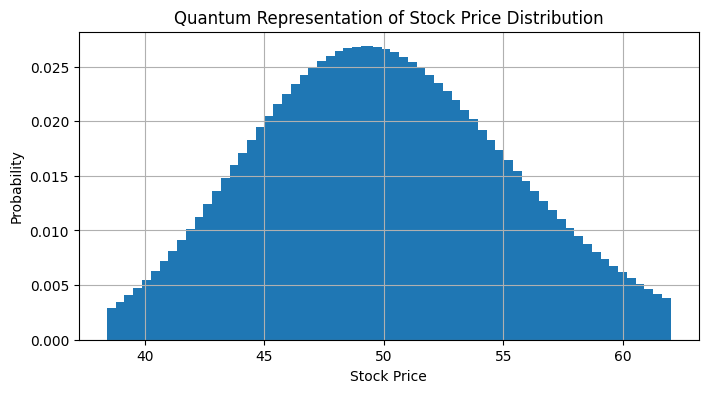

In [ ]:
# Parameters
num_uncertainty_qubits = 6   # 64 possible stock prices at once.
S0 = 50                        # Initial stock price
K = 55                       # Strike price
r = 0.05                       # Risk-free interest rate
sigma = 0.4                    # Volatility
T = 30 / 365                # Time to maturity (in years)



# Log-normal distribution parameters
mu = (r - 0.5 * sigma**2) * T + np.log(S0)
sigma_t = sigma * np.sqrt(T)
mean = np.exp(mu + sigma_t**2 / 2)
var = (np.exp(sigma_t**2) - 1) * np.exp(2 * mu + sigma_t**2)
std = np.sqrt(var)

# bounds for truncation
low = max(0, mean - 2 * std)
high = mean + 2 * std

# uncertainty model
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma_t**2, bounds=(low, high)
)

# Visualization
x = uncertainty_model.values
y = uncertainty_model.probabilities

plt.figure(figsize=(8, 4))
plt.bar(x, y, width=0.5)
plt.title("Quantum Representation of Stock Price Distribution")
plt.xlabel("Stock Price")
plt.ylabel("Probability")
plt.grid(True)
plt.show()





In [ ]:
# Quantum Estimation setup
sampler = StatevectorSampler()

ae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,
    alpha=0.05,
    sampler=sampler
)


result = ae.estimate(problem)

# Classical comparison
exact_value = np.dot(uncertainty_model.probabilities, np.maximum(0, x - K))
estimated_value = european_call.interpret(result)

print(f"Exact Classical Monte Carlo Value: {exact_value:.4f}")
print(f"Estimated Quantum Value: {estimated_value:.4f}")
print(f"Estimation Error: {abs(exact_value - estimated_value):.4f}")
print(f"Confidence Interval: {result.confidence_interval_processed}")


Exact Classical Monte Carlo Value: 0.4605
Estimated Quantum Value: 0.5870
Estimation Error: 0.1265
Confidence Interval: (np.float64(0.524012919098793), np.float64(0.6499433961065993))


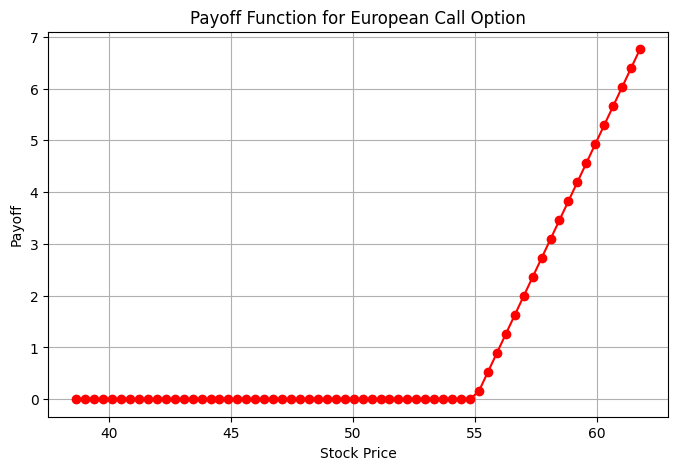

In [ ]:
# Payoff for European Call Option
payoff = np.maximum(0, x - K)
plt.figure(figsize=(8,5))
plt.plot(x, payoff, 'ro-')
plt.title("Payoff Function for European Call Option")
plt.xlabel("Stock Price")
plt.ylabel("Payoff")
plt.grid(True)
plt.show()
